# **Infnet**
## OCR - Reconhecimento Ótico de Caracteres
### **Reconhecimento de Placas de Veículos**
Um sistema que detecta e reconhece placas de veículos de trânsito é conhecido como ANPR/ALPR (Automatic Number/License Plate Recognition). 

Passos do Processo:

1 - Detectar e localizar a placa presente na imagem de entrada (ou frame do vídeo)

2 - Extrair o conteúdo da placa  (letras e números)

3 - Aplicar OCR para reconhecimentos dos caracteres

4 - Retornar o resultado

# Instalação das bibliotecas

## **Tesseract**
* https://www.edivaldobrito.com.br/como-instalar-o-tesseract-ocr-no-ubuntu-mint-debian-e-derivados/

* https://ironsoftware.com/csharp/ocr/blog/ocr-tools/tesseract-ocr-windows/

* https://pypi.org/project/pytesseract/

* https://nanonets.com/blog/ocr-with-tesseract/

* https://pythonforundergradengineers.com/how-to-install-pytesseract.html

Tesseract é um mecanismo de OCR de código aberto mais preciso que lê uma ampla variedade de formatos de imagem e os converte em texto em mais de 40 idiomas

## **OpenCV (CV2)**
* https://pypi.org/project/opencv-python/
* https://blog.xpeducacao.com.br/opencv-em-python/
* https://docs.opencv.org/4.x/d2/d96/tutorial_py_table_of_contents_imgproc.html
* https://pythonprogramming.net/loading-images-python-opencv-tutorial/
* https://www.geeksforgeeks.org/opencv-python-tutorial/

In [ ]:
!sudo apt install tesseract-ocr 
!pip install pytesseract 
!mkdir tessdata #Cria pasta
!wget -O ./tessdata/por.traineddata https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-525
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘tessdata’: File exists
--2023-04-05 01:21:07--  https://github.com/tesseract-ocr/tessdata/blob/main/por.traineddata?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata [following]
--2023-04-05 01:21:07--  https://github.com/tesseract-ocr/tessdata/raw/main/por.traineddata
Reusing existing connection 

# Connection to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!mkdir images

In [ ]:
!cp -R *.jpg /content/gdrive/MyDrive/imagens/ images

cp: cannot stat '*.jpg': No such file or directory


# Importando as bibliotecas

In [ ]:
import cv2
import numpy as np
import imutils
import pytesseract
from matplotlib import pyplot as plt

In [ ]:
def show_img(img):
  fig = plt.gcf()
  fig.set_size_inches(16, 8)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

# Pre-processing the image

In [ ]:
# Link da imagem: https://img0.icarros.com/dbimg/imgnoticia/4/24777_1
img = cv2.imread('/content/images/imagens/6.jpg')
(H, W) = img.shape[:2]
print(H, W)

450 635


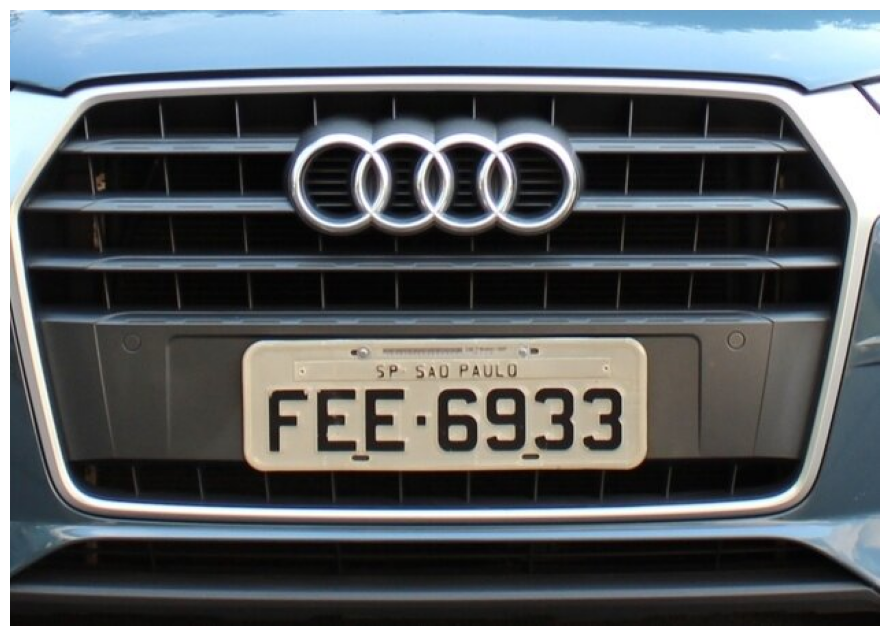

In [ ]:
show_img(img)

## Grayscale

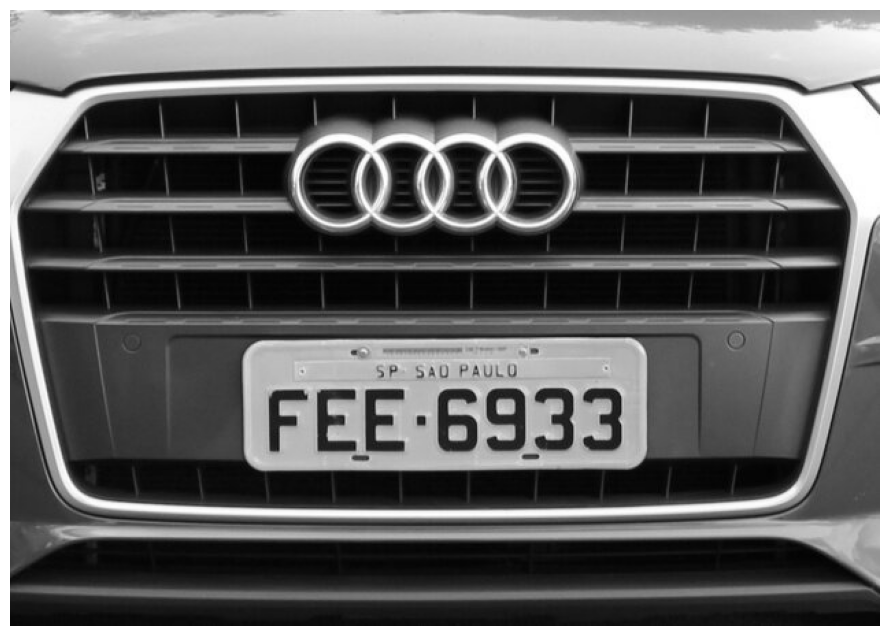

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_img(gray)

## Blur 
Desfoque - remoção de ruídos

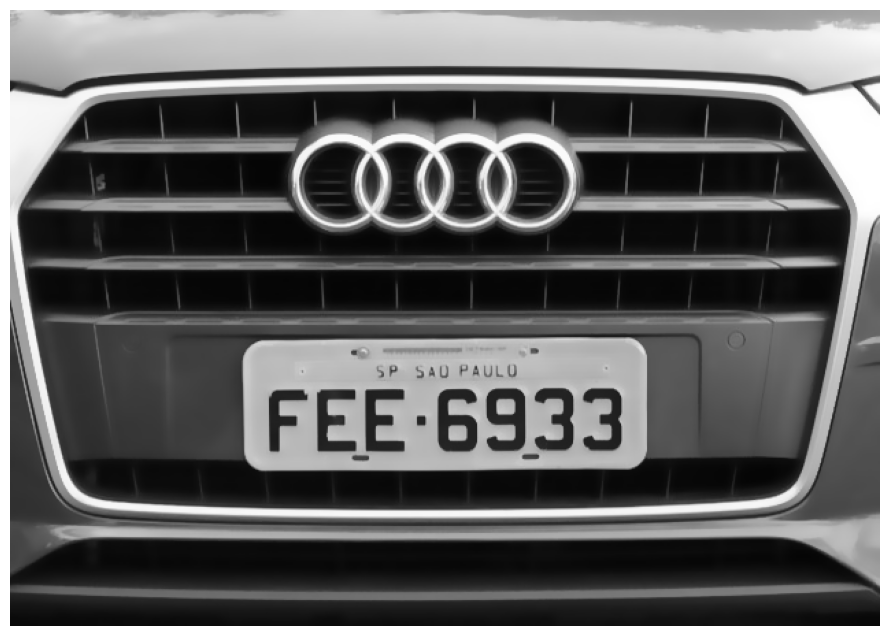

In [ ]:
blur = cv2.bilateralFilter(gray, 11, 17, 17)
show_img(blur)

## Edges (Canny Edge)
Detecção das bordas

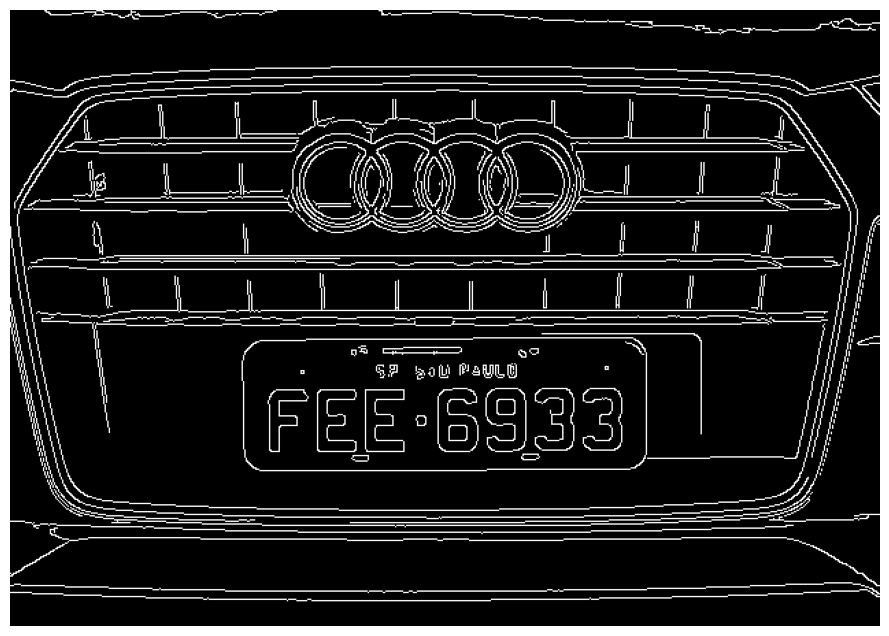

In [ ]:
edged = cv2.Canny(blur, 30, 200) 
show_img(edged)

## Contours
Detecção de contornos

In [ ]:
conts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
conts = imutils.grab_contours(conts) 
conts = sorted(conts, key=cv2.contourArea, reverse=True)[:8] 

In [ ]:
#conts # Lista todos os contornos encontrados

## Finding the region
Encontrando a região onde a placa está

In [ ]:
location = None
for c in conts:
    peri = cv2.arcLength(c, True)
    aprox = cv2.approxPolyDP(c, 0.02 * peri, True) # contorno que tenha os cantos
    if cv2.isContourConvex(aprox):
      if len(aprox) == 4: #4 cantos
          location = aprox
          break

In [ ]:
location # Localização da placa

array([[[464, 250]],

       [[182, 241]],

       [[171, 326]],

       [[456, 334]]], dtype=int32)

In [ ]:
mask = np.zeros(gray.shape, np.uint8)  #mascara com zeros
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
mask.shape

(450, 635)

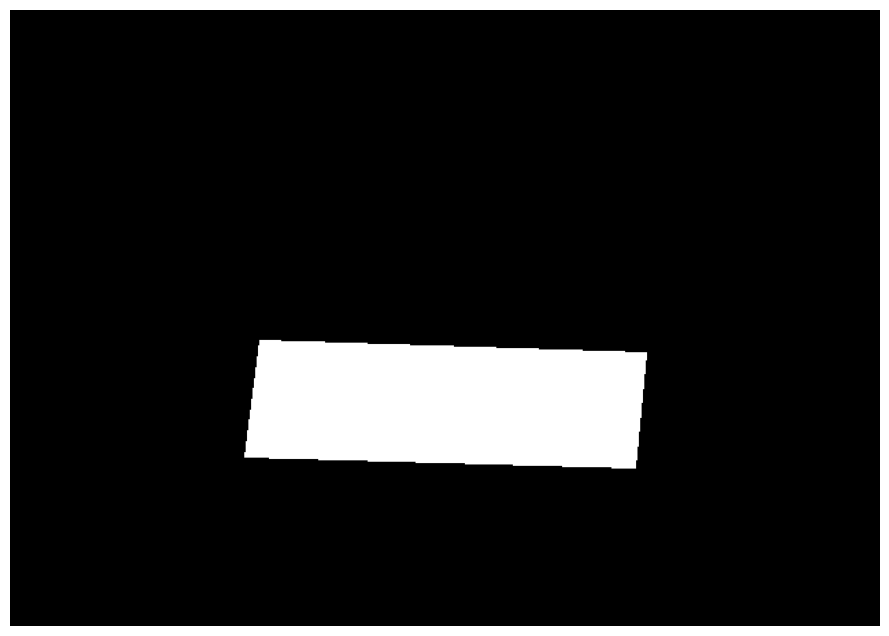

In [ ]:
img_plate = cv2.drawContours(mask, [location], 0, 255, -1) #Desenho com a localização da placa
show_img(mask)

In [ ]:
img_plate = cv2.bitwise_and(img, img, mask=mask) #para a parte branca atribuir o RGA da imagem original

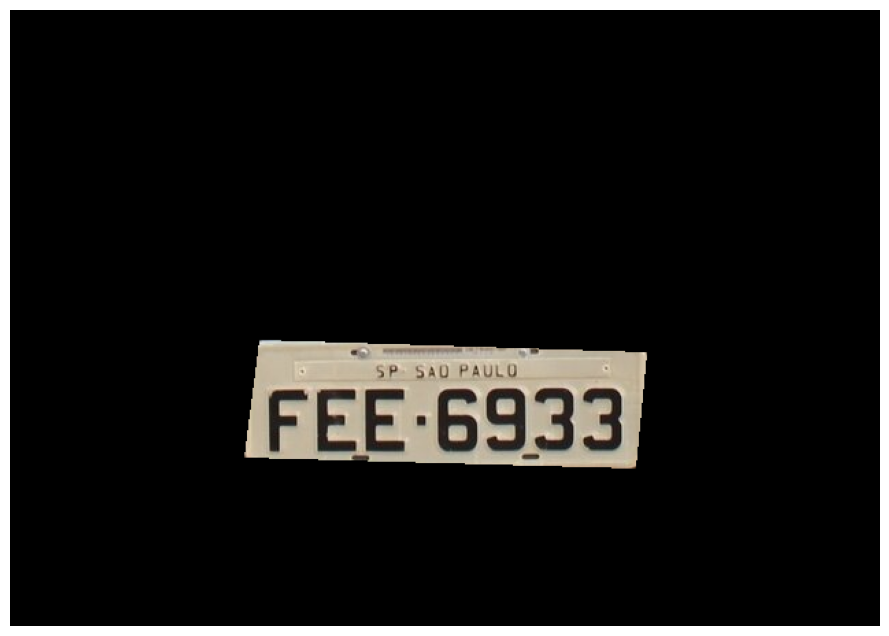

In [ ]:
show_img(img_plate)

In [ ]:
# Seleciona somente a região da placa
(y, x) = np.where(mask==255) #Retorna os pontos, somente da máscara
(beginX, beginY) = (np.min(x), np.min(y))
(endX, endY) = (np.max(x), np.max(y))

In [ ]:
beginX, beginY, endX, endY #Coordenadas da placa

(171, 241, 464, 334)

In [ ]:
plate = gray[beginY:endY, beginX:endX]

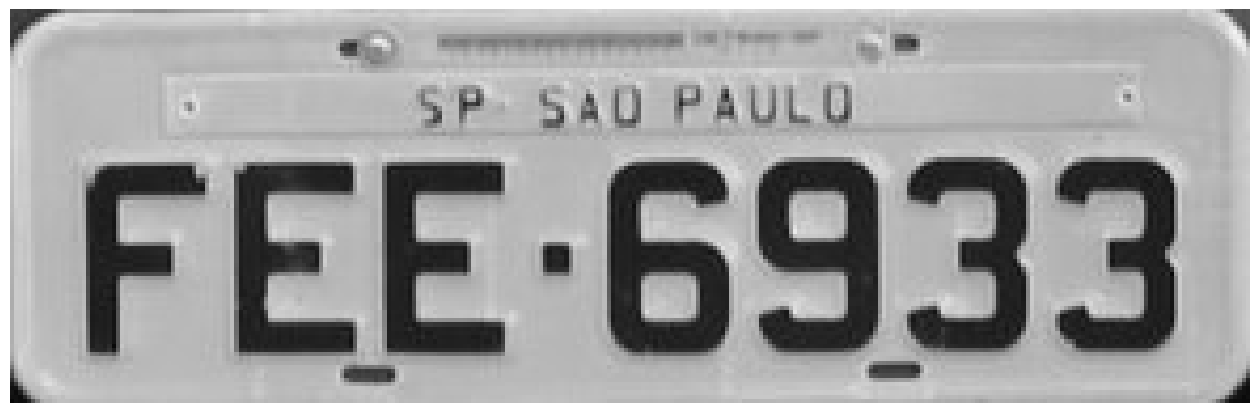

In [ ]:
show_img(plate) # Somente a parte que nos interessa

# Text recognition
OCR - Reconhecimento ótico de caracteres


In [ ]:
config_tesseract = "--tessdata-dir tessdata --psm 6"

In [ ]:
!tesseract --help-psm

Page segmentation modes:
  0    Orientation and script detection (OSD) only.
  1    Automatic page segmentation with OSD.
  2    Automatic page segmentation, but no OSD, or OCR. (not implemented)
  3    Fully automatic page segmentation, but no OSD. (Default)
  4    Assume a single column of text of variable sizes.
  5    Assume a single uniform block of vertically aligned text.
  6    Assume a single uniform block of text.
  7    Treat the image as a single text line.
  8    Treat the image as a single word.
  9    Treat the image as a single word in a circle.
 10    Treat the image as a single character.
 11    Sparse text. Find as much text as possible in no particular order.
 12    Sparse text with OSD.
 13    Raw line. Treat the image as a single text line,
       bypassing hacks that are Tesseract-specific.


In [ ]:
text = pytesseract.image_to_string(plate, lang="por", config=config_tesseract) # Passa a imagem como parâmetro
print(text)

FEE:6933



In [ ]:
text #Retorna caracteres especiais

'FEE:6933\n\x0c'

In [ ]:
text = "".join(character for character in text if character.isalnum()) # isalnum retorna somente alfanuméricos
text

'FEE6933'

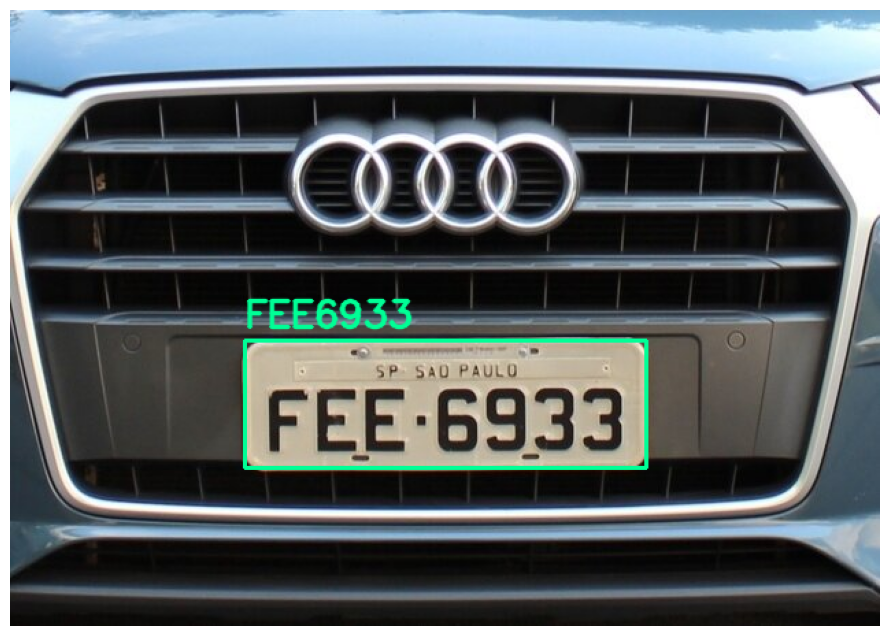

In [ ]:
img_final = cv2.putText(img, text, (beginX, beginY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (150,255,0), 2, lineType=cv2.LINE_AA)
img_final = cv2.rectangle(img, (beginX, beginY), (endX, endY), (150, 255, 0), 2)
show_img(img_final)

In [ ]:
# Função detectar placa
def detect_plate(file_img):
  img = cv2.imread(file_img)
  (H, W) = img.shape[:2]
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blur = cv2.bilateralFilter(gray, 11, 17, 17)
  edged = cv2.Canny(blur, 30, 200)
  show_img(edged)
  conts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
  conts = imutils.grab_contours(conts) 
  conts = sorted(conts, key=cv2.contourArea, reverse=True)[:8] 

  location = None
  for c in conts:
    peri = cv2.arcLength(c, True)
    aprox = cv2.approxPolyDP(c, 0.02 * peri, True)
    if cv2.isContourConvex(aprox):
      if len(aprox) == 4:
          location = aprox
          break

  beginX = beginY = endX = endY = None
  if location is None:
    plate = False
  else:
    mask = np.zeros(gray.shape, np.uint8) 

    img_plate = cv2.drawContours(mask, [location], 0, 255, -1)
    img_plate = cv2.bitwise_and(img, img, mask=mask)

    (y, x) = np.where(mask==255)
    (beginX, beginY) = (np.min(x), np.min(y))
    (endX, endY) = (np.max(x), np.max(y))

    plate = gray[beginY:endY, beginX:endX]
    show_img(plate)

  return img, plate, beginX, beginY, endX, endY

In [ ]:
# Função OCR
def ocr_plate(plate):
  config_tesseract = "--tessdata-dir tessdata --psm 6"
  text = pytesseract.image_to_string(plate, lang="por", config=config_tesseract)
  text = "".join(c for c in text if c.isalnum())
  return text

In [ ]:
# Reconhecimento
def recognize_plate(file_img):
  img, plate, beginX, beginY, endX, endY = detect_plate(file_img)
  
  if plate is False:
    print("It was not possible to detect!")
    return 0

  text = ocr_plate(plate)
  print(text)
  img = cv2.putText(img, text, (beginX, beginY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (150,255,0), 2, lineType=cv2.LINE_AA)
  img = cv2.rectangle(img, (beginX, beginY), (endX, endY), (150, 255, 0), 2)
  show_img(img)

  return img, plate

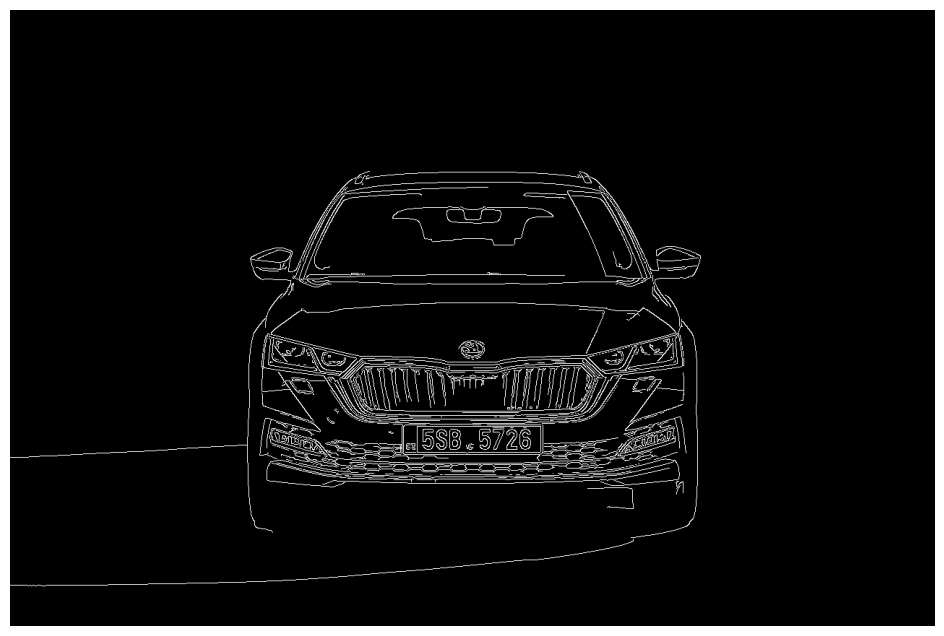

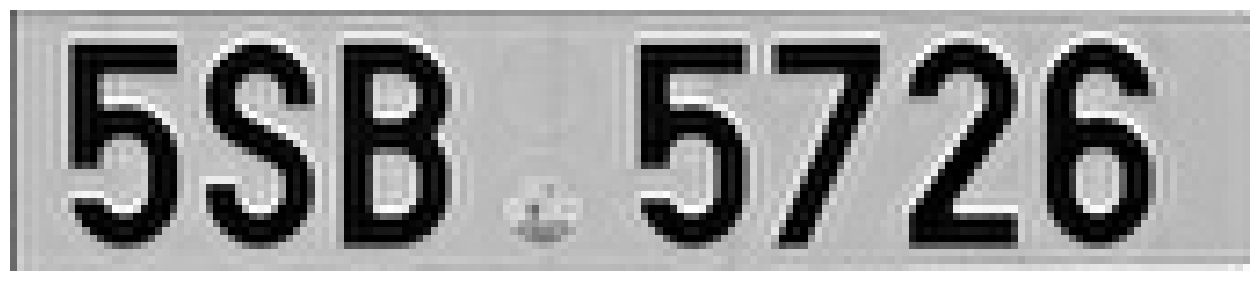

5SB5726


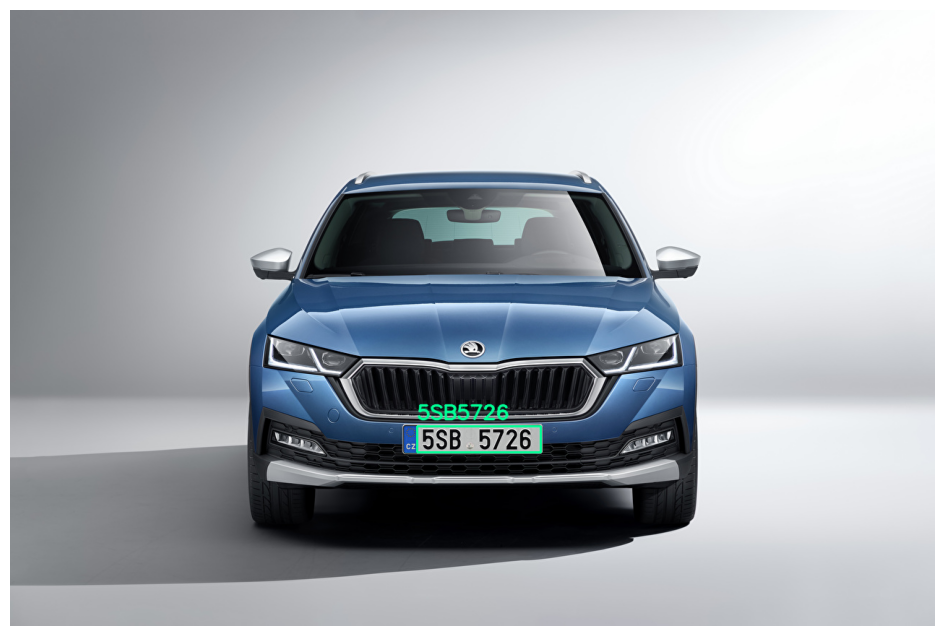

In [ ]:
img, plate = recognize_plate('/content/images/imagens/8.jpg')

# **Links Úteis**
## License Plate Recognition
* https://medium.com/programming-fever/license-plate-recognition-using-opencv-python-7611f85cdd6c
* https://www.youtube.com/watch?v=NApYP_5wlKY
* https://pyimagesearch.com/2020/09/21/opencv-automatic-license-number-plate-recognition-anpr-with-python/
* https://www.makeuseof.com/python-car-license-plates-detect-and-recognize/
* https://github.com/topics/license-plate-recognition?l=python